In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 病种高套（BZGY）小样本建模

注： 本notebook 使用fastai2, 请升级 pip install -U fastai
https://docs.fast.ai/
1. ULMFIT encoder
    *  a. 使用全量的门诊住院单据，训练RNN语言模型LM
    *  b. 使用DRGS住院单据，精调RNN语言模型LM
    *  c. 迁移LM Encoder到分类器模型，训练DRGS明细诊断分类器
2.  Prototypical network(https://arxiv.org/abs/1703.05175)
    *  a. 通过抽样生成 N-Way,K-shot episode
    *  b. 使用1c 的RNN encoder，整合protonet 训练神经网络
    *  c. 测试性能
        - 训练集中包含的类别
        - 训练集未包含的类别
  

 

  
  

## Data Processing (只需运行一次）

In [ ]:

import pyspark.sql.functions as pyspark_F
from tqdm import tqdm

from fastai import *
from fastai.text import *
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.functions import pandas_udf,PandasUDFType,concat_ws,collect_list
from pyspark.sql.types import *

# spark.stop()
conf = SparkConf().setAppName('BZGT').setMaster('local[*]')
spark = SparkSession.builder.config(conf=conf).config("spark.driver.memory", "35g").config("spark.local.dir", "/media/data1/data/tmp").getOrCreate()
spark

In [ ]:
DETAIL_PATH_INHOSP = "./data/inHosp/detail"
detail_full = spark.read.parquet(DETAIL_PATH_INHOSP)
data_full = detail_full.select(["REGISTER_NO","MED_PROJECT_NAME"]).groupby("REGISTER_NO").agg(concat_ws(",", collect_list("MED_PROJECT_NAME")).alias("details"))
data = data_full.toPandas()


In [ ]:
data.to_parquet("./data/lm.parquet")
data

In [ ]:
REGISTER_PATH = "./data/inHosp/register"
DETAIL_PATH = "./data/inHosp/detail"
COMBINED_PATH = "./data/inHosp/combined"

#从医保报销的单据表中抽取住院单据以及其对应明细清单
register = spark.read.parquet(REGISTER_PATH)
detail = spark.read.parquet(DETAIL_PATH)
combine = spark.read.parquet(COMBINED_PATH)
print(register.count())
print(detail.count())
print(combine.count())

### filter out diseases with few samples

min_sample = 200

icd_diagnosis = \
register.select(['out_hosp_diagnosisname','out_hosp_diagnosiscode']).dropna().\
filter(pyspark_F.length("out_hosp_diagnosiscode")>=5).\
withColumn("ICD4", register.out_hosp_diagnosiscode.substr(0,5)).\
groupby(['out_hosp_diagnosisname','ICD4']).count().\
filter(f"count >= {min_sample}").\
sort(["out_hosp_diagnosisname",]).collect()

icd_diagnosis_dict = {}
for row in icd_diagnosis:
    icd_diagnosis_dict[row.ICD4] = row.out_hosp_diagnosisname
len(icd_diagnosis_dict)

data_inhosp = \
combine.filter(pyspark_F.length("out_hosp_diagnosiscode")>=5).\
withColumn("ICD4", combine.out_hosp_diagnosiscode.substr(0,5)).\
filter(pyspark_F.col('ICD4').isin(list(icd_diagnosis_dict.keys()))).toPandas()

In [ ]:
!rm ./data/*.parquet

In [ ]:
DETAIL_PATH_INHOSP = "./data/inHosp/detail"
detail_full = spark.read.parquet(DETAIL_PATH_INHOSP)
data_full = detail_full.select(["REGISTER_NO","MED_PROJECT_NAME"]).groupby("REGISTER_NO").agg(concat_ws(",", collect_list("MED_PROJECT_NAME")).alias("details"))
data = data_full.toPandas()

REGISTER_PATH = "./data/inHosp/register"
DETAIL_PATH = "./data/inHosp/detail"
COMBINED_PATH = "./data/inHosp/combined"

#从医保报销的单据表中抽取住院单据以及其对应明细清单
register = spark.read.parquet(REGISTER_PATH)
detail = spark.read.parquet(DETAIL_PATH)
combine = spark.read.parquet(COMBINED_PATH)
print(register.count())
print(detail.count())
print(combine.count())

### filter out diseases with few samples

min_sample = 200

icd_diagnosis = \
register.select(['out_hosp_diagnosisname','out_hosp_diagnosiscode']).dropna().\
filter(pyspark_F.length("out_hosp_diagnosiscode")>=5).\
withColumn("ICD4", register.out_hosp_diagnosiscode.substr(0,5)).\
groupby(['out_hosp_diagnosisname','ICD4']).count().\
filter(f"count >= {min_sample}").\
sort(["out_hosp_diagnosisname",]).collect()

icd_diagnosis_dict = {}
for row in icd_diagnosis:
    icd_diagnosis_dict[row.ICD4] = row.out_hosp_diagnosisname
len(icd_diagnosis_dict)

data_inhosp = \
combine.filter(pyspark_F.length("out_hosp_diagnosiscode")>=5).\
withColumn("ICD4", combine.out_hosp_diagnosiscode.substr(0,5)).\
filter(pyspark_F.col('ICD4').isin(list(icd_diagnosis_dict.keys()))).toPandas()

In [ ]:
data_inhosp.to_parquet("./data/drgs.parquet")
data_inhosp

## ULMFIT - train LM using full dataset

In [ ]:
from fastai.basics import *
from fastai.text.all import *


In [ ]:
lm = pd.read_parquet("./data/lm.parquet")
lm

In [ ]:
splits = RandomSplitter(valid_pct=0.1, seed=42)(lm)
splits


In [ ]:
tls = TfmdLists(lm, [attrgetter("text"), 
                     Tokenizer.from_df(text_cols='details', 
                                       tok=SubwordTokenizer(max_vocab_sz=5000)), Numericalize],splits=splits,
                dl_type=LMDataLoader)


In [ ]:
dataloader = tls.dataloaders(bs=256, seq_len=160)

In [ ]:
dataloader.show_batch(max_n=3, trunc_at=60)

In [ ]:
import pickle
pickle.dump(dataloader.vocab, open("./lm_vocab.pickle", "wb"))  # save it into a file named save.p

vocab = pickle.load(open("./lm_vocab.pickle", "rb"))
assert dataloader.vocab == vocab

In [ ]:
config = awd_lstm_lm_config.copy()
config

In [ ]:
learner = language_model_learner(dataloader, AWD_LSTM, pretrained=False,metrics=[accuracy], config=config)

In [ ]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


In [ ]:
learner = learner.to_fp16()

In [ ]:
learner.unfreeze()
# learner.load('1epoch')

learner.fit_one_cycle(1, 5e-3)



In [ ]:
learner.save_encoder('lm')


## fine tune language model using DRGS data

In [ ]:
from fastai.basics import *
from fastai.text.all import *


drgs = pd.read_parquet("./data/drgs.parquet")
drgs

In [ ]:
splits = RandomSplitter(valid_pct=0.1, seed=42)(drgs)
splits


In [ ]:
vocab = pickle.load(open("./lm_vocab.pickle", "rb"))
vocab

In [ ]:
tls = TfmdLists(drgs, [attrgetter("text"), 
                     Tokenizer.from_df(text_cols='details', 
                                       tok=SubwordTokenizer(sp_model='./tmp/spm.model')), Numericalize(vocab=vocab)],splits=splits,
                dl_type=LMDataLoader)


In [ ]:
dataloader = tls.dataloaders(bs=256, seq_len=160)
dataloader.show_batch()

In [ ]:
learner = language_model_learner(dataloader, AWD_LSTM, pretrained=False,metrics=[accuracy])

In [ ]:
learner.load_encoder('lm')

In [ ]:
learner.lr_find()

In [ ]:

learner.fit_one_cycle(1, 2e-2)

In [ ]:
learner.save_encoder('drgs')

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(1, 2e-2)

In [ ]:
learner.save_encoder('drgs')

In [ ]:
learner.predict(['胰岛素'],n_words=100)

## Train classifier using drgs fine-tuned encoder 

In [118]:
from fastai.basics import *
from fastai.text.all import *


drgs = pd.read_parquet("./data/drgs.parquet")
drgs


from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(drgs[['details','ICD4']],test_size=0.1,stratify=drgs[['ICD4']])
X_train.shape,X_test.shape


((76480, 2), (8498, 2))

In [119]:
vocab = pickle.load(open("./lm_vocab.pickle", "rb"))

x_tfms = [attrgetter("text"), 
                        Tokenizer.from_df(text_cols='details', 
                                       tok=SubwordTokenizer(sp_model='./tmp/spm.model')), Numericalize(vocab=vocab)]

y_tfms = [ColReader('ICD4'), Categorize()]

In [120]:
splits = RandomSplitter(valid_pct=0.1, seed=42)(X_train)
splits


((#68832) [66233,1520,43578,71826,30332,71564,50199,28235,74829,30305...],
 (#7648) [33702,67440,49980,56840,38146,60040,9798,498,47294,3282...])

In [121]:
dsets = Datasets(X_train,[x_tfms, y_tfms] ,splits=splits,dl_type=SortedDL)


dls = dsets.dataloaders(bs=64,before_batch=pad_input_chunk)
dls.show_batch()

/media/data1/ubuntu/repository/zhaohang/RiskAnalytics/src/main/python/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"▁xxbos ▁ , 肺通气功能检查 , 丙泊酚 , 一次性鼻导管 , 血清碱性磷酸酶测定 , 预知子 ( 配 方 颗粒 ), 持续呼吸功能监测 , 多潘立酮 , 普通病房床位费 , 血浆 d - 二 聚 体测定 ( d - d im er ), 血清高密度脂蛋白胆固醇测定 , 无机磷测定 , 常规心电图检查 , 血清白蛋白测定 , 胰酶 , 陈皮 ( 配 方 颗粒 ), 一次性过滤器 , 阿托品 , 乙肝表面抗 体测定 ( an t i - hbs ), 血清天门冬氨酸氨基转移酶测定 , 肠 排 列 术 ( 固定术 ), 布地奈德 , 心电监护 , 中心 监护 病房床位费 ( 14 日 内 ), 依托咪酯 , 麻醉恢复室监护 , 一次性延长管 , 微量泵或输液泵加收 , 深静脉导管 , 抗 j o -1 抗体测定 , 甘草 ( 配 方 颗粒 ), 电凝切割器 , 胺碘酮 , 抗 p m - sc i 抗体测定 , 乙肝 e 抗原测定 ( hbe ag ), 维生素 b 6, 压力传感器 , 硝酸甘油 , 乳酸脱氢酶测定 , 红细胞 比 积测定 ( hc t ), 中心静脉 压 测定 , 白术 ( 配",Z85.9
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad ▁xxbos ▁ , 屈他维林 , 骨髓特殊染色及酶组织化学染色检查 , 丙泊酚 , 一次性鼻导管 , 胞磷胆碱 ( 胞 二 磷胆碱 ), 手工分 冰冻 血浆 ( f fp ), 持续呼吸功能监测 , 沙丁胺醇 , 普通病房床位费 , 血浆 d - 二 聚 体测定 ( d - d im er ), 常规心电图检查 , 层流洁净...",K56.7
2,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad ▁xxbos ▁ , 戊 型肝炎抗体 测定 ( igg ), rh 阴性 红细胞悬液 , 雷贝拉唑 , 参麦注射液 , 磁 共 振 扫描 ( 永 磁 型 ), 丙泊酚 , 一次性鼻导管 , 血清碱性磷酸酶测定 , 红细胞 沉 降 率 测定 ( e s r ), 多潘立酮 , 沙丁胺醇 , 普通病房床位费 , 尿素测定 ( 急诊...",K92.2
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xx...,C18.9
4,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xx...,C34.9
5,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xx...,C16.9
6,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad 

In [122]:
# save ICD to index map for later
import pickle
pickle.dump(dls.categorize.vocab, open("./categorize_vocab.pickle", "wb"))  # save it into a file named save.p


In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

In [123]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5,lin_ftrs=[600,300], metrics=accuracy)


In [129]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(4640, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(4640, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=600, bias=False)
        (3): ReLU(inplace=True)

In [ ]:
# learn = learn.load("classifier")

In [125]:
learn = learn.load_encoder('drgs')


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.00363078061491251)

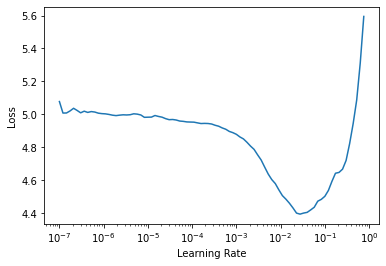

In [126]:
learn.lr_find()

In [132]:
learn.fit_one_cycle(4, 3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,1.648748,1.827209,0.526151,02:51
1,1.560205,1.792284,0.533734,02:52
2,1.578078,1.774404,0.542103,02:52
3,1.453282,1.739610,0.546810,02:54


In [ ]:
lr=1e-2
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/10/(2.6**4),lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,1.275517,1.617632,0.568253,06:55
1,1.303509,1.577558,0.562500,06:55
2,1.222806,1.584961,0.572829,07:04
3,1.216910,1.565089,0.573876,06:49
4,1.152769,1.538229,0.580152,06:49
5,1.129440,1.564903,0.586559,06:54
6,1.050473,1.561171,0.589958,07:04


In [178]:
learn.save("classifier")

Path('models/classifier.pth')

### test classifier performance

In [1]:
def load_rnn_learner(test_df, model_fn='classifier'):
    """
    test_df: data to predicate 
    model_fn: exported model file name
    """
    vocab = pickle.load(open("./lm_vocab.pickle", "rb"))
    categorize_vocab =  pickle.load(open("./categorize_vocab.pickle", "rb"))

    x_tfms = [attrgetter("text"), 
                            Tokenizer.from_df(text_cols='details', 
                                           tok=SubwordTokenizer(sp_model='./tmp/spm.model')), Numericalize(vocab=vocab)]

    y_tfms = [ColReader('ICD4'), Categorize(vocab = categorize_vocab)]

    test_dl = Datasets(test_df,[x_tfms, y_tfms],dl_type=SortedDL).dataloaders(bs=64,before_batch=pad_input_chunk)
    learn = text_classifier_learner(test_dl, AWD_LSTM, lin_ftrs=[600,300], drop_mult=0.5, metrics=accuracy)
    learn.load(model_fn)
    return learn

## Prototypical network

In [2]:
from fastai.basics import *
from fastai.text.all import *


drgs = pd.read_parquet("./data/drgs.parquet")
drgs


from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(drgs[['details','ICD4']],test_size=0.1,stratify=drgs[['ICD4']])
X_train.shape,X_test.shape


((76480, 2), (8498, 2))

###  Episode

In [3]:
from fastai.text.all import *
import pandas as pd
from pandas import DataFrame
from dataclasses import dataclass


# Episode is the basic unit for prototypical network training
@dataclass
class Episode:
    idx:int
    n_way: int
    k_shot: int
    # datum: [{label: 'E14', query_set : [dt1,dt2...], support_set : [dt1,dt2,...]},]
    datum: list

    def _convert_to_df(self):
        output = []
        assert len(self.datum) == self.n_way
        for d in self.datum:
            assert d['label'] is not None
            assert len(d['query_set']) == self.k_shot
            assert len(d['query_set']) == len(d['support_set'])
            for a, b in zip(d['query_set'], d['support_set']):
                output.append({'label': d['label'], 'query_set': a, 'support_set': b})
        return pd.DataFrame(output)

    def __len__(self):
        return len(datum)

    def show(self, ctx=None, display=False, **kwargs):
        df = self._convert_to_df()
        if display:
            print(f"{self.idx} th {self.n_way} Way, {self.k_shot} Shot Episode")
            display_df(df)
        return df




###  Dataloader


In [4]:
# generate an episode by sampling
class EpisodeGen(Transform):
    def __init__(self, data, n_way=64, k_shot=5):
        self.df = data.set_index("ICD4")
        self.n_way = n_way
        self.k_shot = k_shot
        assert n_way <= self.df.index.nunique()

    def _extract(self):
        output = []
        lbl_list = np.random.permutation(self.df.index.unique())
        n = 0
        for cls in lbl_list:
            xs = np.random.permutation(self.df.loc[cls].details)
            if len(xs) >= 2 * self.k_shot:
                output.append({
                    'label': cls,
                    'query_set': xs[:self.k_shot],
                    'support_set': xs[self.k_shot: 2 * self.k_shot]
                })
                n += 1
                if n >= self.n_way:
                    return output
        raise Exception("not enough data to make an episode")

    def encodes(self, o):
        return Episode(o, self.n_way, self.k_shot, self._extract())


In [5]:
# vecterize an episode
class EpisodeVectorizer(Transform):
    def __init__(self,
                 tokenizer,
                 numericalizer,
                 categorize):
        self.cat = categorize
        self.x_proc = Pipeline([tokenizer, numericalizer])

    # tuple of tensors ((n*k, l),(n*k, l),(n*k,))
    def encodes(self, o):

        df = o._convert_to_df()
        cls = TfmdLists(df.label, self.cat)
        query = TfmdLists(df.query_set, self.x_proc)
        support = TfmdLists(df.support_set, self.x_proc)
        return list(support),list(query), tensor(cls)


In [6]:
# pad query and support to be the same length, use chunk_pad in front as pad_input_chunk
class ChunkPadder(ItemTransform):
    # same logic as pad_input_chunk in fast_ai
    def pad_chunk(self, vec_list, pad_idx=1, pad_first=True, seq_len=72):
        max_len = max([len(s) for s in vec_list])
        def _f(x):
            l = max_len - x.shape[0]
            pad_chunk = x.new_zeros((l // seq_len) * seq_len) + pad_idx
            pad_res = x.new_zeros(l % seq_len) + pad_idx
            x1 = torch.cat([pad_chunk, x, pad_res]) if pad_first else torch.cat([x, pad_res, pad_chunk])
            return retain_type(x1, x)

        return torch.stack([_f(s) for s in vec_list])

    # tuple of tensors ((n*k, l),(n*k, l),(n*k,))
    def encodes(self, o):
        a, b, c = o
        return self.pad_chunk(a), self.pad_chunk(b), c


In [7]:
def get_pipe(train_data, n_way, k_shot, n_episode, validation=0.1):
    vocab = pickle.load(open("./lm_vocab.pickle", "rb"))
    categorize_vocab =  pickle.load(open("./categorize_vocab.pickle", "rb"))

    etk = EpisodeVectorizer(Tokenizer(SubwordTokenizer(sp_model='./tmp/spm.model')),
                           Numericalize(vocab=vocab),
                           Categorize(vocab = categorize_vocab))
    tfms = [EpisodeGen(train_data,n_way,k_shot), etk,ChunkPadder()]
    items = range(0, n_episode)
    splits = RandomSplitter(valid_pct=0.1, seed=42)(items)
    
    return TfmdLists(items, tfms, splits=splits)


In [8]:
class ReorderTarget(ItemTransform):
    """ 重新对target 排序，从0 到 N-way, 每个k_shot """
    order = 10

    def __init__(self, n_way, k_shot):
        self.n_way = n_way
        self.k_shot = k_shot

    def encodes(self, o):
        x1, x2, target = o
        target_inds = torch.arange(0, self.n_way).view(self.n_way, 1, 1).expand(self.n_way, self.k_shot, 1)\
        .long().reshape(self.n_way* self.k_shot).contiguous().to(x1.device)
        return [x1.squeeze(), x2.squeeze(), target_inds]


In [9]:
def get_dl(train_data,n_way, k_shot, n_episode, validation=0.1):
    l = get_pipe(train_data, n_way, k_shot, n_episode, validation)
    dl = l.dataloaders(bs=1,after_batch=[ReorderTarget(n_way, k_shot)])
    return dl

### PrototypicalNetwork model

#### Encoder from trained classifier model

In [10]:
# remove last layer of classifer to use as encoder
def get_rnn_encoder(data, encoder_fn='classifier'):
    text_learner = load_rnn_learner(data,encoder_fn)
    remain_layers = text_learner.model[1].layers[:-1]
    text_learner.model[1].layers = nn.Sequential(*remain_layers)
    return text_learner.model


#### Prototypical network

In [43]:
BatchNorm(300, ndim=1)

BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [44]:
class ProtoNet(Module):
    def __init__(self,  n_way, k_shot, encoder,norm=True):
        """
               Args:
                   encoder :  encoding sample as vectors
                   n_way (int): number of classes in a classification task
                   n_support (int): number of labeled examples per class in the support set
                   n_query (int): number of labeled examples per class in the query set
               """
        store_attr('norm,n_way,k_shot,encoder')
        self.bn= BatchNorm(300, ndim=1)

    def reset(self):
        for c in self.children(): getattr(c, 'reset', noop)()

    def forward(self, x1, x2):
        # x1, x2 shape (n_way * k_shot, length)
        z_support,raw_out_1,out_1 = self.encoder(x1)
        z_query,raw_out_2,out_2 = self.encoder(x2)
        
        z_support = self.bn(z_support)
        z_query = self.bn(z_query)
        z_support_mean = z_support.view(self.n_way, self.k_shot, -1).mean(1)

        # compute distances
        dists = self.euclidean_dist(z_query, z_support_mean)

        return -dists,raw_out_1,out_1,raw_out_2,out_2

    def euclidean_dist(self, x, y):
        """
        Computes euclidean distance btw x and y
        Args:
            x (torch.Tensor): shape (n, d). n usually n_way*n_query
            y (torch.Tensor): shape (m, d). m usually n_way
        Returns:
            torch.Tensor: shape(n, m). For each query, the distances to each centroid
        """
#         if self.norm:
#             x = F.normalize(x, p=2, dim=1)
#             y = F.normalize(y, p=2, dim=1)

        n = x.size(0)
        m = y.size(0)
        d = x.size(1)
        assert d == y.size(1)

        a = x.unsqueeze(1).expand(n, m, d)
        b = y.unsqueeze(0).expand(n, m, d)
        return torch.pow(a - b, 2).sum(2)



### ProtoNet Learner

#### Regularization Callback + Learner

In [45]:
# used for regularizing RNNs
class DualRNNRegularizer(Callback):
    "`Callback` that adds AR and TAR regularization in RNN training"

    def __init__(self, alpha=0., beta=0.):
        self.alpha, self.beta = alpha, beta

    def after_pred(self):
#         import pdb
#         pdb.set_trace()

        self.raw_out1 = self.pred[1][-1] if is_listy(self.pred[1]) else self.pred[1]
        self.out1 = self.pred[2][-1] if is_listy(self.pred[2]) else self.pred[2]
        self.raw_out2 = self.pred[3][-1] if is_listy(self.pred[3]) else self.pred[3]
        self.out2 = self.pred[4][-1] if is_listy(self.pred[4]) else self.pred[4]
        self.learn.pred = self.pred[0]

    @staticmethod
    def TAR(h):
        return (h[:, 1:] - h[:, :-1]).float().pow(2).mean()

    def after_loss(self):
#         import pdb
#         pdb.set_trace()

        if not self.training: return
        if self.alpha != 0.:  self.learn.loss += self.alpha * (
                self.out1.float().pow(2).mean() + self.out2.float().pow(2).mean())
        if self.beta != 0.:
            h1 = self.raw_out1
            h2 = self.raw_out2
            if len(h1) > 1 and len(h2)>1: self.learn.loss += self.beta * (self.TAR(h1) + self.TAR(h2))

In [46]:
@delegates(Learner.__init__)
class ProtonetLearner(Learner):
    def __init__(self, dls, model, alpha=0, beta=0, moms=(0.8, 0.7, 0.8),
                 loss_func=CrossEntropyLossFlat(),
                 metrics=[accuracy],
                 splitter=lambda m: awd_lstm_clas_split(m.encoder), # reuse AWD_RNN's grouping
                 **kwargs):
        super().__init__(dls, model, moms=moms,metrics=metrics, loss_func=loss_func, splitter=splitter, **kwargs)
        self.add_cbs([ModelResetter(), DualRNNRegularizer(alpha=alpha, beta=beta)])

    def save_encoder(self, file):
        "Save the encoder to `file` in the model directory"
        if rank_distrib(): return  # don't save if child proc
        encoder = get_model(self.model).encoder
        if hasattr(encoder, 'module'): encoder = encoder.module
        torch.save(encoder.state_dict(), join_path_file(file, self.path / self.model_dir, ext='.pth'))

    def load_encoder(self, file, device=None):
        "Load the encoder `file` from the model directory, optionally ensuring it's on `device`"
        encoder = get_model(self.model).encoder
        if device is None: device = self.dls.device
        if hasattr(encoder, 'module'): encoder = encoder.module
        distrib_barrier()
        wgts = torch.load(join_path_file(file, self.path / self.model_dir, ext='.pth'), map_location=device)
        encoder.load_state_dict(clean_raw_keys(wgts))
        self.model.to(device)
        self.freeze()
        return self

In [47]:
def get_protonet_learner(data, n_way=64, k_shot=5, episode=200, encoder_fn='classifier', norm_distance=True):
    dls = get_dl(data,n_way,k_shot,episode)
    encoder = get_rnn_encoder(data[:1000],encoder_fn=encoder_fn)
    protonet = ProtoNet(n_way,k_shot, encoder, norm=norm_distance).to(dls.device)
    learner = ProtonetLearner(dls, protonet)
    learner.freeze()
    return learner

#### Training

In [15]:
from fastai.basics import *
from fastai.text.all import *
from sklearn.model_selection import train_test_split


drgs = pd.read_parquet("./data/drgs.parquet")

X_train, X_test = train_test_split(drgs[['details','ICD4']],test_size=0.1,stratify=drgs[['ICD4']])
X_train.shape,X_test.shape


((76480, 2), (8498, 2))

proto_learner.fit_one_cycle(5,0.01)

proto_learner.save_encoder("protonet")

In [52]:
proto_learner = get_protonet_learner(X_train,episode=50, n_way=64,norm_distance=False)
# proto_learner.load_encoder("protonet")

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=3.981071586167673e-06)

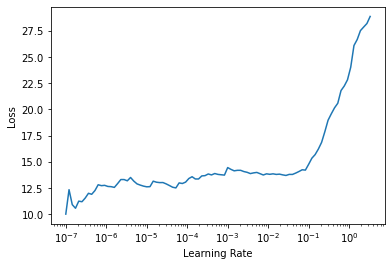

In [58]:
proto_learner.lr_find()

In [56]:
proto_learner.fit_one_cycle(10, 0.003)


epoch,train_loss,valid_loss,accuracy,time
0,14.427350,15.601711,0.641250,01:06
1,14.525838,13.791516,0.630625,01:06
2,14.729288,13.331526,0.617500,01:06
3,14.399564,18.325760,0.636250,01:06
4,14.697748,11.815753,0.588750,01:06
5,13.637397,18.865473,0.609375,01:06
6,13.546111,11.084041,0.634375,01:06
7,13.709325,14.132014,0.652500,01:05
8,13.427780,8.513739,0.640000,01:06
9,13.687536,15.876904,0.614375,01:06


In [59]:
proto_learner.save_encoder('protonet')

In [60]:
proto_learner.freeze_to(-2)
proto_learner.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,time
0,15.372581,10.455886,0.619375,01:20


In [ ]:
proto_learner.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,time
0,14.799774,14.987992,0.615000,01:19


In [18]:
proto_learner.load_encoder("protonet")

In [ ]:
proto_learner.freeze_to(-3)
proto_learner.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.585778,1.569434,0.727500,00:48
1,1.580312,1.545497,0.750000,00:48
2,1.602022,1.453379,0.802500,00:49
3,1.599353,1.498283,0.710000,00:50
4,1.585953,1.544689,0.747500,00:48
5,1.589514,1.533703,0.725000,00:49


In [16]:
proto_learner = get_protonet_learner(X_train,episode=50, n_way=10,norm_distance=True)
proto_learner.load_encoder("protonet")
proto_learner.unfreeze()
proto_learner.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))

/media/data1/ubuntu/repository/zhaohang/RiskAnalytics/src/main/python/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,time
0,1.217861,1.139583,0.812000,00:45
1,1.235609,1.139354,0.840000,00:45
2,1.236290,1.118956,0.820000,00:46
3,1.239017,1.227138,0.792000,00:46
4,1.252598,1.120858,0.828000,00:46
5,1.235767,1.169444,0.852000,00:45
6,1.237995,1.125464,0.864000,00:45
7,1.223287,1.166305,0.828000,00:46
8,1.236006,1.125309,0.824000,00:45
9,1.251802,1.181110,0.788000,00:46


In [17]:
proto_learner.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.239025,1.170236,0.844000,00:45
1,1.220237,1.126152,0.840000,00:46
2,1.241367,1.115978,0.824000,00:47
3,1.232871,1.156473,0.836000,00:46
4,1.248081,1.219365,0.776000,00:46
5,1.252839,1.121109,0.848000,00:46
6,1.254053,1.198496,0.808000,00:46
7,1.234936,1.137378,0.808000,00:45
8,1.236497,1.235000,0.768000,00:46
9,1.237091,1.200744,0.816000,00:46


In [18]:
proto_learner.save_encoder("protonet")

#### inference

In [21]:
proto_learner = get_protonet_learner(X_test,episode=10, n_way=64,norm_distance=True)


/media/data1/ubuntu/repository/zhaohang/RiskAnalytics/src/main/python/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
preds = proto_learner.get_preds(ds_idx=0,reorder=False)


In [25]:
preds[0].shape,preds[1].shape

(torch.Size([2880, 64]), torch.Size([2880]))

In [24]:
torch.eq(torch.argmax(preds[0],dim=1), preds[1]).float().mean()

tensor(0.5396)

In [26]:
proto_learner.load_encoder("protonet")
preds = proto_learner.get_preds(ds_idx=0,reorder=False)


In [27]:
torch.eq(torch.argmax(preds[0],dim=1), preds[1]).float().mean()

tensor(0.5090)

In [ ]:
pred_icd = [y_tfms[1].vocab[i] for i in (torch.argmax(preds[0],dim=1).numpy())]
target =[y_tfms[1].vocab[i] for i in preds[1].numpy()]

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

print(classification_report(list(pred_icd),list(target)))